# Overview

## Lecture 8: fMRI hemodynamic response function and convolution

In this session, we will learn about the hemodynamic response function and how *convolve* a signal with this function.

In the last few weeks, we computed event-related averages for responses to different categories of objects. We saw that responses in fMRI emerge slowly (2-3 TRs or 4-6 seconds) after the onset of a stimulus.

In an fMRI experiment, we usually would like to know how some event is related to brain responses and where in the brain we can find representations of these events. Using the event related averages we can investigate which brain regions respond more to a particular stimuli than others. This week, we will introduce how we can model the slow nature of the fMRI signal. To drive any valid conclusions from the fMRI data we need to make sure that our events model the actual changes in the brain. By modeling the delay that is inate to the fMRI signal, we can later try to find a direct mapping between the event and the brain response (which we will see in in the lectures after the Spring break).

# Goals for today

We will go over some important concepts of how to incorporate the delan in the fMRI signal after a stimulus (or event) onset 

- Neuroscience concepts
    - Modeling hemodynamic responses
- Coding concepts
    - Implementing convolution
- Datascience concepts
    - Time series convolution
    - Correlation 

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# Configure defaults for plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['image.cmap'] = 'viridis'

# New defaults!
from cycler import cycler
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.prop_cycle'] = cycler('color', ['k','r', (0,0,0.8),(0.95,0.8,0),(0,.8,0),(1.0, 0.5, 0)])

In [2]:
# Update neurods
import neurods as nds
nds.io.update_neurods()

NameError: name 'nds' is not defined

In [2]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina' # prettier plots for retina screens (optional)

# fMRI responses do not occur immediately after a stimulus

fMRI responses emerge slowly after the onset of a stimulus (or any other event). This means that, if we want to make an accurate mathematical model of how the brain responds to a given stimulus, we have to incorporate this delay into our model. 

To do this, we will borrow a concept from signal processing theory called the impulse response function. An impulse response function describes a system's response (this can be the signal that we measure using fMRI) to an external change (e.g. the stimulus or event onset). As we know, fMRI measures BOLD signal and not neuronal activity directly. Therefore, to model the hemodynamic response (BOLD signal) to an event we would like to have a function that describes how the BOLD signal looks like when it responds to a given event. This function is called the *hemodynamic response function* or HRF. 

A great deal of early fMRI research went into accurately describing how the BOLD signal rises, falls, and resets to baseline after an event. We will rely on the conclusions of this research without going into much detail about it. For an overview of hemodynamic responses in fMRI, check out [this blog post](http://mindhive.mit.edu/node/72), and the papers in the `figures/` directory for this lecture (Handwerker, Bandettini et al 2012; Logothetis & Wandell, 2004). The practical upshot of this work is that BOLD responses have a fairly characteristic shape, which is well described by a mathematical function called the *gamma function*. 


#### Generate and plot the hemodynamic response function

Below we will use the fmri module in the neurods package to generate a canonical HRF:

`neurods.fmri.hrf()`

In [10]:
# Let's check what arguments this function takes
import neurods
neurods.fmri.hrf??

hrf_1 shape is (32,)


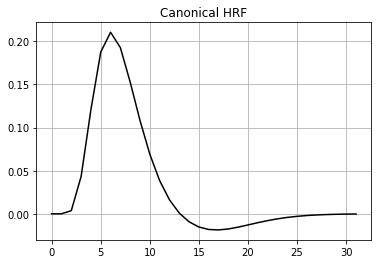

In [3]:
# Import a function that generates an HRF
from neurods.fmri import hrf as generate_hfr

# Set the TR, or repetition time, a.k.a. the sampling rate
TR = 1.0 # One measurement per second

# Get a canonical HRF
t_hrf, hrf_1 = generate_hfr(tr=TR)
print('hrf_1 shape is', hrf_1.shape)
__ = plt.plot(t_hrf, hrf_1)
plt.title("Canonical HRF")

#### Plot a single discrete stimulus

<Container object of 3 artists>

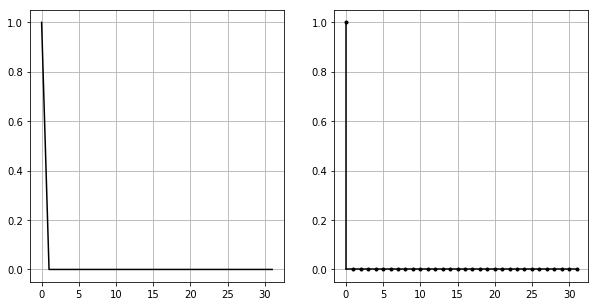

In [7]:
# Plot a single discrete stimulus that appears at time 0
t = t_hrf
stimulus = np.zeros(t.shape)
stimulus[0] = 1

plt.figure(1, figsize=(10, 5))
plt.subplot(121)
plt.plot(t, stimulus)

# There is a better function that we can use to make this plot more explicit
#plt.subplot(122)
#plt.stem(t, stimulus, linefmt='k-', markerfmt='.', basefmt='k-', label='Stimulus')

#### The HRF is the BOLD response to this single discrete stimulus

Let's plot the HRF together with the stimulus

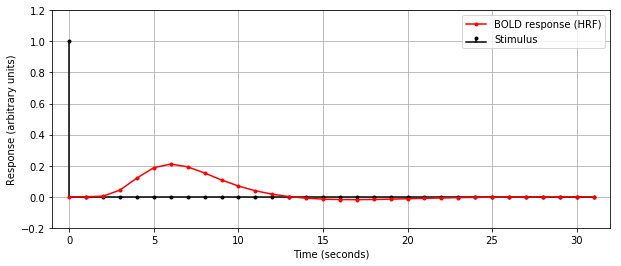

In [8]:
# We will be plotting stimulus / response pairs several times
# Hence, here is a function that can plot these two together
def stim_resp_plot(t, stimulus, response, yl=(-0.2, 1.2)):
    """Plot stimulus and response."""
    plt.figure(figsize=(10,4))
    plt.stem(t, stimulus, linefmt='k-', markerfmt='.', basefmt='k-', label='Stimulus')
    plt.plot(t, response, 'r.-', label='BOLD response (HRF)')
    plt.ylim(yl)
    plt.xlim([-1,t.max()+1])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Response (arbitrary units)')
    _ = plt.legend()

# Plot
stim_resp_plot(t, stimulus, hrf_1)

### Breakout session
Play with the parameters of the `neurods.fmri.hrf()` function. See what happens if you change them. 

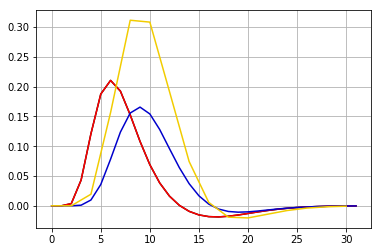

In [27]:
### STUDENT ANSWER
plt.plot(*neurods.fmri.hrf())
plt.plot(*neurods.fmri.hrf(pttp=5, tr=1))
plt.plot(*neurods.fmri.hrf(pttp=8))
plt.plot(*neurods.fmri.hrf(pttp=8, tr=2))

Every time an event occurs, the response we measure is similar to this slow hemodynamic response. We will slowly explore how this hemodynamic response can affect the signal in a voxel.

First, we start with a hypothetical run of 200 TRs, in which no stimuli is presented.

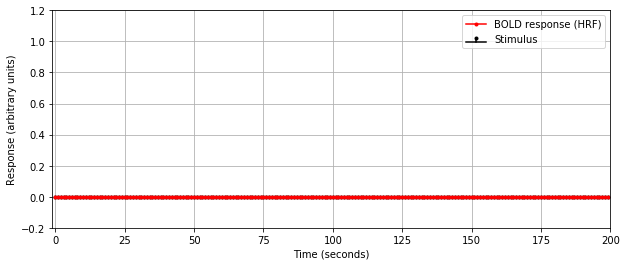

In [28]:
n = 200 # Total time points (TRs)
t = np.arange(n,)
# no stimulus
stimuli = np.zeros((n))
# we assume no response
response = np.zeros((n))
# here we plot the function
stim_resp_plot(t, stimuli, response, yl=(-0.2, 1.2))
# and see nothing as predicted.

### Breakout session (a)

A few cells above we plotted how the signal changes when we have a stimulus at time 0. 

Now, imagine we have a stimulus at time `i=10`. What do you expect will happen when we plot the stimulus and response?

Hint: This stimulus will create an HRF that will be *added* to the signal from times i to times i + hrf_length (hrf_length is the length of our canonical HRF, which was 32 above).

Attention: Make sure you modify the response by adding something to it's values, and not only changing it.

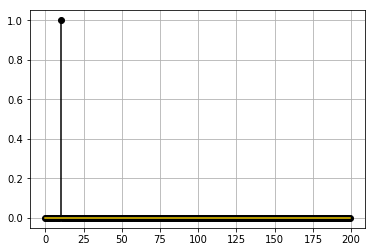

In [50]:
t_hrf, hrf_1 = generate_hfr(tr=TR)
hrf_length = len(hrf_1)
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))
response = np.zeros((n))

# Add a stimlus onset at time 10
i = 10
stimuli[i] = 1
plt.stem(t, stimuli)

# Now add the response to stimulus i to the response, then plot using stim_resp_plot like above
### STUDENT ANSWER
#response[range(i,i+hrf_length)] += hrf_1
#stim_resp_plot(t, stimuli, response, yl=(-0.2, 1.2))

### Breakout session (b)


Now let's say that there were 3 event onsets, one at `i=10`, one at `i=70` and one at `i=150`, plot the resulting activity. 

<Container object of 3 artists>

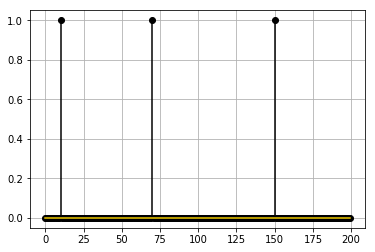

In [53]:
t_hrf, hrf_1 = generate_hfr(tr=TR)
hrf_length = len(hrf_1)
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))
response = np.zeros((n))

stim_times = [10, 70, 150]
for i in stim_times:
    stimuli[i] = 1
    
plt.stem(t, stimuli)

# Now add the response to these three events, then plot using stim_resp_plot like above
### STUDENT ANSWER
#for i in stim_times:
#    response[range(i,i+hrf_length)] += hrf_1
#stim_resp_plot(t, stimuli, response, yl=(-0.2, 1.2))

### Breakout session (c)

Now say that the stimuli are closer together than the length of the hemodynamic function: let's say they occur at times 10, 21, 25, 70, 71,74, 75, 80 and 150, what happens? 

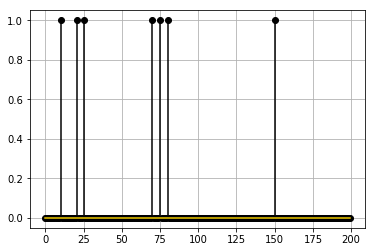

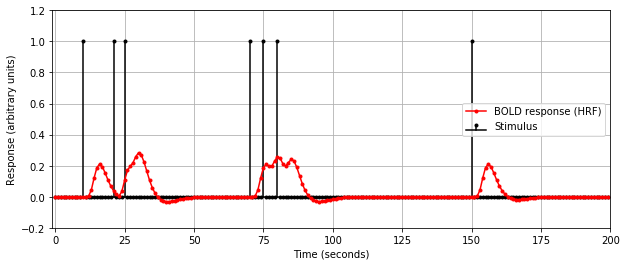

In [55]:
t_hrf, hrf_1 = generate_hfr(tr=TR)
hrf_length = len(hrf_1)
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))
response = np.zeros((n))

stim_times = [10, 21, 25, 70, 75, 80, 150]
for i in stim_times:
    stimuli[i] = 1
plt.stem(t, stimuli)

# Now add the response to these events to the response, then plot using stim_resp_plot like above
### STUDENT ANSWER
#for i in stim_times:
#    response[range(i,i+hrf_length)] += hrf_1
#stim_resp_plot(t, stimuli, response, yl=(-0.2, 1.2))

### Breakout session (d)
What happens if the event appears at time `i=180`? 

Hint: You may need to make a change involving the min function.

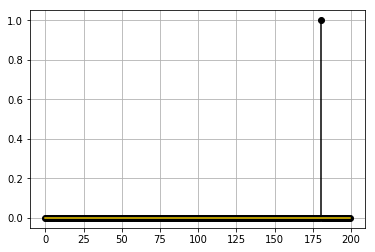

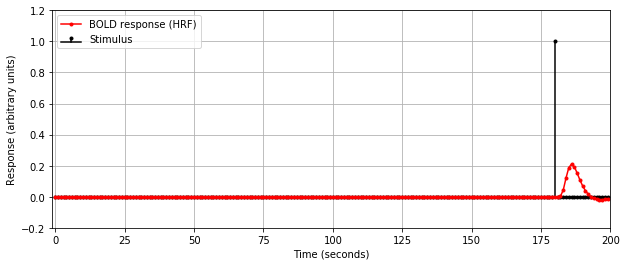

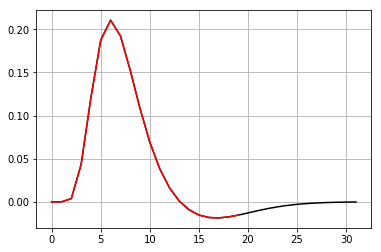

In [70]:
t_hrf, hrf_1 = generate_hfr(tr=TR)
hrf_length = 32
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))
response = np.zeros((n))

stim_times = [180]
for i in stim_times:
    stimuli[i] = 1
plt.stem(t, stimuli)

# Now add the response to this event to the response, then plot using stim_resp_plot like above
### STUDENT ANSWER
#for i in stim_times:
#    index = range(i, min(i+hrf_length, n))
#    response[index] += hrf_1[:len(index)]
#stim_resp_plot(t, stimuli, response, yl=(-0.2, 1.2))

#plt.figure()
#plt.plot(hrf_1)
#plt.plot(hrf_1[:len(index)])

### Breakout session (e)

Now write a function that will produce the correct response vectors given the stimulus vector and the hrf_1 vector. Make sure that the function will go over every element in the stimulus vector. You might need to do an adjustment to the last breakout session (d).

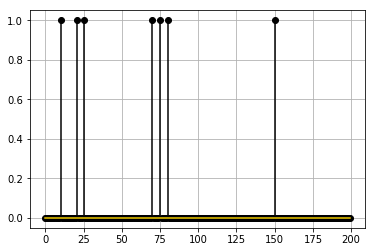

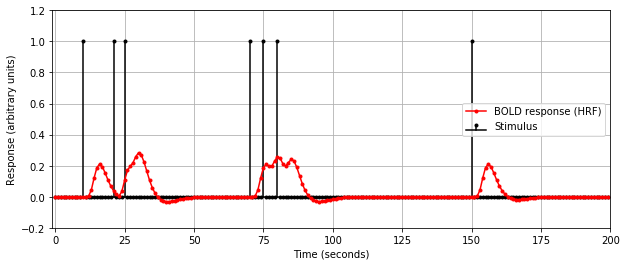

In [71]:
t_hrf, hrf_1 = generate_hfr(tr=TR)
hrf_length = len(hrf_1)
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))

stim_times = [10, 21, 25, 70, 75, 80, 150]
for i in stim_times:
    stimuli[i] = 1

plt.stem(t, stimuli)
    
# Define your function here, then use it to generate output and plot the above plots:
def gen_responses(stimulus_vec, hrf_canonical):
    n = stimulus_vec.shape[0]
    hrf_length = len(hrf_canonical)
    response = np.zeros((n,))
    for i in range(n):
### STUDENT ANSWER
        if stimulus_vec[i]==1: # one way to do it: only if I have a stimulus, I will add a response
            index = range(i, min(i+hrf_length, n))
            response[index] += hrf_canonical[:len(index)]
    return response

response = gen_responses(stimuli,hrf_1)
stim_resp_plot(t, stimuli, response, yl=(-0.2, 1.2))

### Breakout session (f)

Now assume that the events occur with different intensities: for example, a tactile stimulus with different levels of intensities. 

We will assume that the measured response to each event is proportional to the intensity of the event.  So, please modify the function `gen_responses` from Breakout session (e) to adjust for this change in intensity for each event.

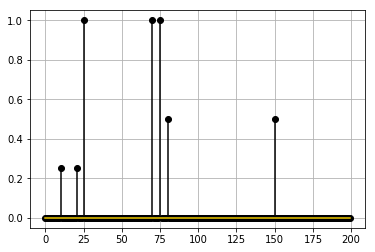

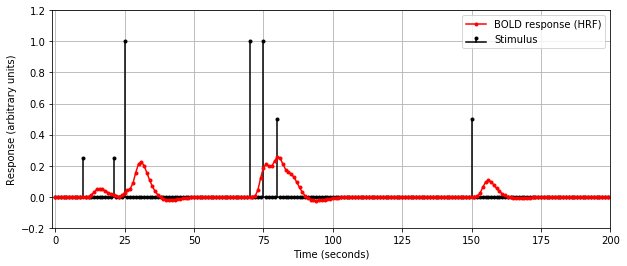

In [72]:
t_hrf, hrf_1 = generate_hfr(tr=TR)
hrf_length = len(hrf_1)
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))

stim_times = [10, 21, 25, 70, 75, 80, 150]
stim_intensities = [0.25, 0.25, 1, 1, 1, 0.5, 0.5]
for idx, i_time in enumerate(stim_times):
    stimuli[i_time] = stim_intensities[idx]

plt.stem(t, stimuli)
    
# Define your function here, then use it to generate output and plot the above plots:
def gen_responses(stimulus_vec, hrf_canonical):
    n = stimulus_vec.shape[0]
    hrf_length = len(hrf_canonical)
    response = np.zeros((n,))
    for i in range(n):
### STUDENT ANSWER
        index = range(i, min(i+hrf_length,n) )
        response[index] +=  stimuli[i]*hrf_canonical[:len(index)]
    return response

response = gen_responses(stimuli,hrf_1)
stim_resp_plot(t, stimuli, response, yl=(-0.2, 1.2))

In [ ]:
### TEACHER NOTE
# Make sure to specify that the new hrfs should be added, i.e. the signal shouldn't 
# just be changed directly.

### Breakout session (g)

This time assume that we have a _blocked_ stimulus, i.e. the simulus is on for 30 seconds, starting at 10, 70 and 130. How will the response change?

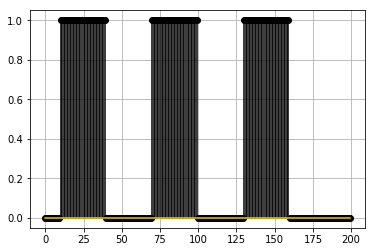

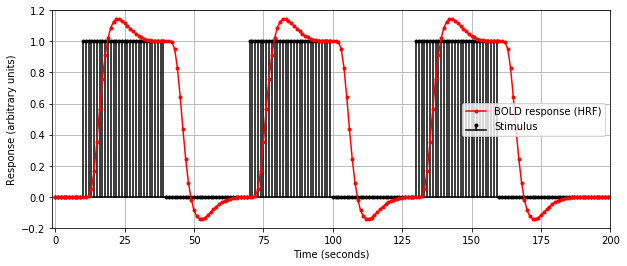

In [73]:
t_hrf, hrf_1 = generate_hfr(tr=TR)
hrf_length = 32
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))

stim_times = list(range(10, 40)) + list(range(70, 100))+ list(range(130, 160))
for i in stim_times:
    stimuli[i] = 1
plt.stem(t, stimuli)
    
# you can use your function here again, then use it to generate output and plot the above plots:
def gen_responses(stimulus_vec, hrf_canonical):
    n = stimulus_vec.shape[0]
    hrf_length = len(hrf_canonical)
    response = np.zeros((n,))
    for i in range(n):
### STUDENT ANSWER
        index = range(i, min(i+hrf_length,n) )
        response[index] +=  stimuli[i]*hrf_canonical[:len(index)]
    return response

response = gen_responses(stimuli,hrf_1)
stim_resp_plot(t, stimuli, response, yl=(-0.2, 1.2))

Effectively, a train of 30 impulses (or spikes) at the sampling frequency 1 s is the same as having a constant step function for 30 seconds.

What we did in these breakout sessions (a-g) is called a **convolution**: we have a measured signal and the stimulus. The signal is modified by a function, this is in our case the HRF. 

Convolution is an operation where you integrate a given signal with a modifying function. What we did so far is a simplified integration: Because our example was in a discrete time domain, we manually added the contributions of the modifying function (the HRF) to each time point after the event onset.

This is what we did:

If is $T$ the length of the HRF. We went though the events and made it affect the response at later time points. At the end, every value of the response $r(i)$ will have contributions to the stimulus $s$ from the previous $T$ time points:

$r(i) = s(i-1) \times hrf(1) +  s(i-2) \times hrf(2) + ... +  s(i-T+1)  \times hrf(T) \\
  \ \ \   = \Sigma_{\tau=1}^{T} s(i-\tau) \times h(\tau)$

This is exactly the expression of the discrete convolution function between functions $s$ and $h$. In continuous time, the convolution operation is written as:

$r(i) = \int_{\tau=1}^{T} s(i-\tau) \times h(\tau) = s \ast h(i)$

Here we will use a numpy function that is already implemented for this:

In [ ]:
t_hrf, hrf_1 = generate_hrf(tr=TR)
hrf_length = 32
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))
#response = np.zeros((n))

stim_times = list(range(10,40)) + list(range(70,100))+ list(range(130,160))
for i in stim_times:
    stimuli[i] = 1

response = np.convolve(stimuli, hrf_1, mode='full')
print('resulting response has length {} and should be cropped'.format(len(response)))
# Here we also have to crop the signal because np.convolve creates a signal longer than n
# because it computes the response of stimuli appearing up to time n-1, which affect the 
# signal for longer than n.
stim_resp_plot(t, stimuli, response[:n], yl=(-0.2, 1.2))

Let's look at another example: the convolution of a simple periodic signal with the HRF function.

In [ ]:
t_hrf, hrf_1 = generate_hfr(tr=TR)
hrf_length = 32
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))
#response = np.zeros((n))

stim_times = range(0,200,20)
for i in stim_times:
    stimuli[i] = 1
    
### STUDENT ANSWER
response = np.convolve(stimuli, hrf_1, mode='full')
# Here we also have to crop the signal!
stim_resp_plot(t, stimuli, response[:n], yl=(-0.2, 1.2))

And now of overlapping events:

In [ ]:
t_hrf, hrf_1 = generate_hfr(tr=TR)
hrf_length = 32
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))
#response = np.zeros((n))

idx = np.arange(0, n, 20)
stimuli[idx] = 1
add = np.arange(len(idx), 0, -1)
stimuli[idx+add] = 1 
    
### STUDENT ANSWER
response = np.convolve(stimuli, hrf_1, mode='full')
# Here we also have to crop the signal!
stim_resp_plot(t, stimuli, response[:n], yl=(-0.2, 1.2))

### Important Observation 
So far we have assumed that every stimulus occurence creates a response in the voxel equal to the canonical hrf (and can be scaled by the feature value).

However, voxels in different parts of the brain can be differently responsive to a stimulus, or not responsive at all. In fMRI, we are interested in finding how responsive different voxels are to a stimulus. We will therefore introduce a new parameter: $w^v$, that describes the strength with which a voxel $v$ responds to the stimulus:

$ r^v(i) = w^v \times  (s \ast hrf (i) )$

We already know how to compute $s \ast hrf (i)$. In the previous examples we implicitely used $w^v = 1$, and assumed the voxel responds to the stimulus. We will gradually learn how we can estimate $w^v$ from the data, i.e. try to find how responsive voxel $v$ is to a stimulus, if at all. 

Next, we will show you two ways to account for this delay when trying to assess the relationship between brain signals and stimulus events. 

## Looking at example data
For these exercises, we will work with simulated data from a single voxel. We use the same plotting function, but we plot the data that is provided to us instead of forming the responses ourselves.

In [ ]:
# Load example data
ex_data = np.load(os.path.join(nds.io.data_list['fake'], 'example_data_01.npz'))
t = ex_data['t']
stimulus = ex_data['x']
data_sim = ex_data['data']
stim_resp_plot(t, stimulus, data_sim, yl=(-2, 5))

In [ ]:
### TEACHER NOTE
# Note that the data has larger variation than previous examples. We *COULD* z-score it... Or just leave it alone.*

Because of the hemodynamic delay, the fMRI response is *NOT* correlated with the stimulus events:

In [ ]:
plt.scatter(stimulus, data_sim);
print("the correlation between the stimulus and the data is {}".format(np.corrcoef(stimulus, data_sim)[0,1]))

How would the plot above be different if the data had been correlated?

We know that the presentation of the stimulus should create a hemodynamic response if this voxel is sensitive to that stimulus. We therefore need to convolve the stimulus first with the hemodynamic response. 

But first, look at the time vector:

In [ ]:
t[:10]

The data is sampled with a TR of 2 seconds! Then we need an hrf that is sampled with the same rate. This will be the same curve as before, however only sampled differently.

In [ ]:
t2, hrf_2 = nds.fmri.hrf(tr=2)
plt.plot(t2, hrf_2);

Now we can convolve the stimulus:

In [ ]:
conv_stimulus = np.convolve(stimulus, hrf_2, mode='full')[:n_tps]
stim_resp_plot(t, stimulus, conv_stimulus);

In [ ]:
stim_resp_plot(t, conv_stimulus, data_sim, yl=(-2, 5))

In [ ]:
plt.scatter(conv_stimulus, data_sim);
print("the correlation between the stimulus and the data is {}".format(np.corrcoef(conv_stimulus, data_sim)[0,1]))

We can see now we are able to recover a clear relationship between the stimulus and the data. What is the variance of the noise that we can guess from this plot? Had this been real data, this would have been a very clean result. Usually in fMRI we are not so lucky to have effects that are this clear. We will study in future lectures how to can expand this analysis.

Can we estimate from this data the magnitude of the weight $w_v$?

In [ ]:
# this function first a straight line through the points above
slope, intercept = np.polyfit(data_sim,conv_stimulus, 1)
print(slope)

Remember, what is units of this value? FMRI signal doesn't have a unit and can be rescaled and normalized. The weight therefore depends on how the data is normalized and is meaningful only with respect to the variance of the data. 

What happen when we have more than one stimulus?